This notebook is to demonstrate the pytion solution on showing gust information of ECWMF forcast.

Reference: https://www.heywhale.com/mw/project/65d5e3cc1bf0d23bbb4bc435?shareby=620dbd752e0e510017d2f245

In [ ]:
client = Client()

client.retrieve(
    date='2025-02-27',
    time='0',
    step=12,
    stream='oper',
    type="fc",
    param="10fg",
    target="data.grib2",
)

20250224000000-12h-oper-fc.grib2:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

In [ ]:
data = pygrib.open("data.grib2")
print(data)

g = data[1]
lat, lon = g.latlons()

print(g.name)
print(g.units)

Maximum 10 metre wind gust since previous post-processing
m s**-1


In [ ]:
#@title grib2 to nc

filename='data.grib2'
grb = pg.open(filename)
ncname = filename.replace('.grib2','.nc')
da = nc.Dataset(ncname,'w',format='NETCDF4')

g = grb[1]
lat,lon = g.latlons()
da.createDimension('lat',np.size(lat,0))
da.createDimension('lon',np.size(lat,1))

# add lat and lon variables
da.createVariable('lat','f4',('lat','lon'),zlib=True,complevel=9,fill_value=-9999)
da.createVariable('lon','f4',('lat','lon'),zlib=True,complevel=9,fill_value=-9999)
da.variables['lat'][:]=lat
da.variables['lon'][:]=lon

for g in grb:

    # extract data and attribute
    varname = g.name
    data = g.values
    unit = g.units
    level = g.level

    # write into nc file
    if varname=='unknown':
        continue
    if level!=0:
        varname = varname + ' ' + str(level) + 'hPa'
    # print(varname)
    d = da.createVariable(varname,'f4',('lat','lon'),zlib=True,complevel=9,fill_value=-9999)
    d.units = unit
    da.variables[varname][:] = data

da.close()
grb.close()

In [ ]:
ds = xr.open_dataset('data.nc')
# ds["Surface pressure"]
# type(ds["Surface pressure"])
type(ds)
ds = ds.where(lat >= 18).where(lat <= 26).where(lon >= 108).where(lon <= 120)
ds

<xarray.Dataset> Size: 12MB
Dimensions:                                                          (lat: 721,
                                                                      lon: 1440)
Coordinates:
    lat                                                              (lat, lon) float32 4MB ...
    lon                                                              (lat, lon) float32 4MB ...
Data variables:
    Maximum 10 metre wind gust since previous post-processing 10hPa  (lat, lon) float32 4MB ...

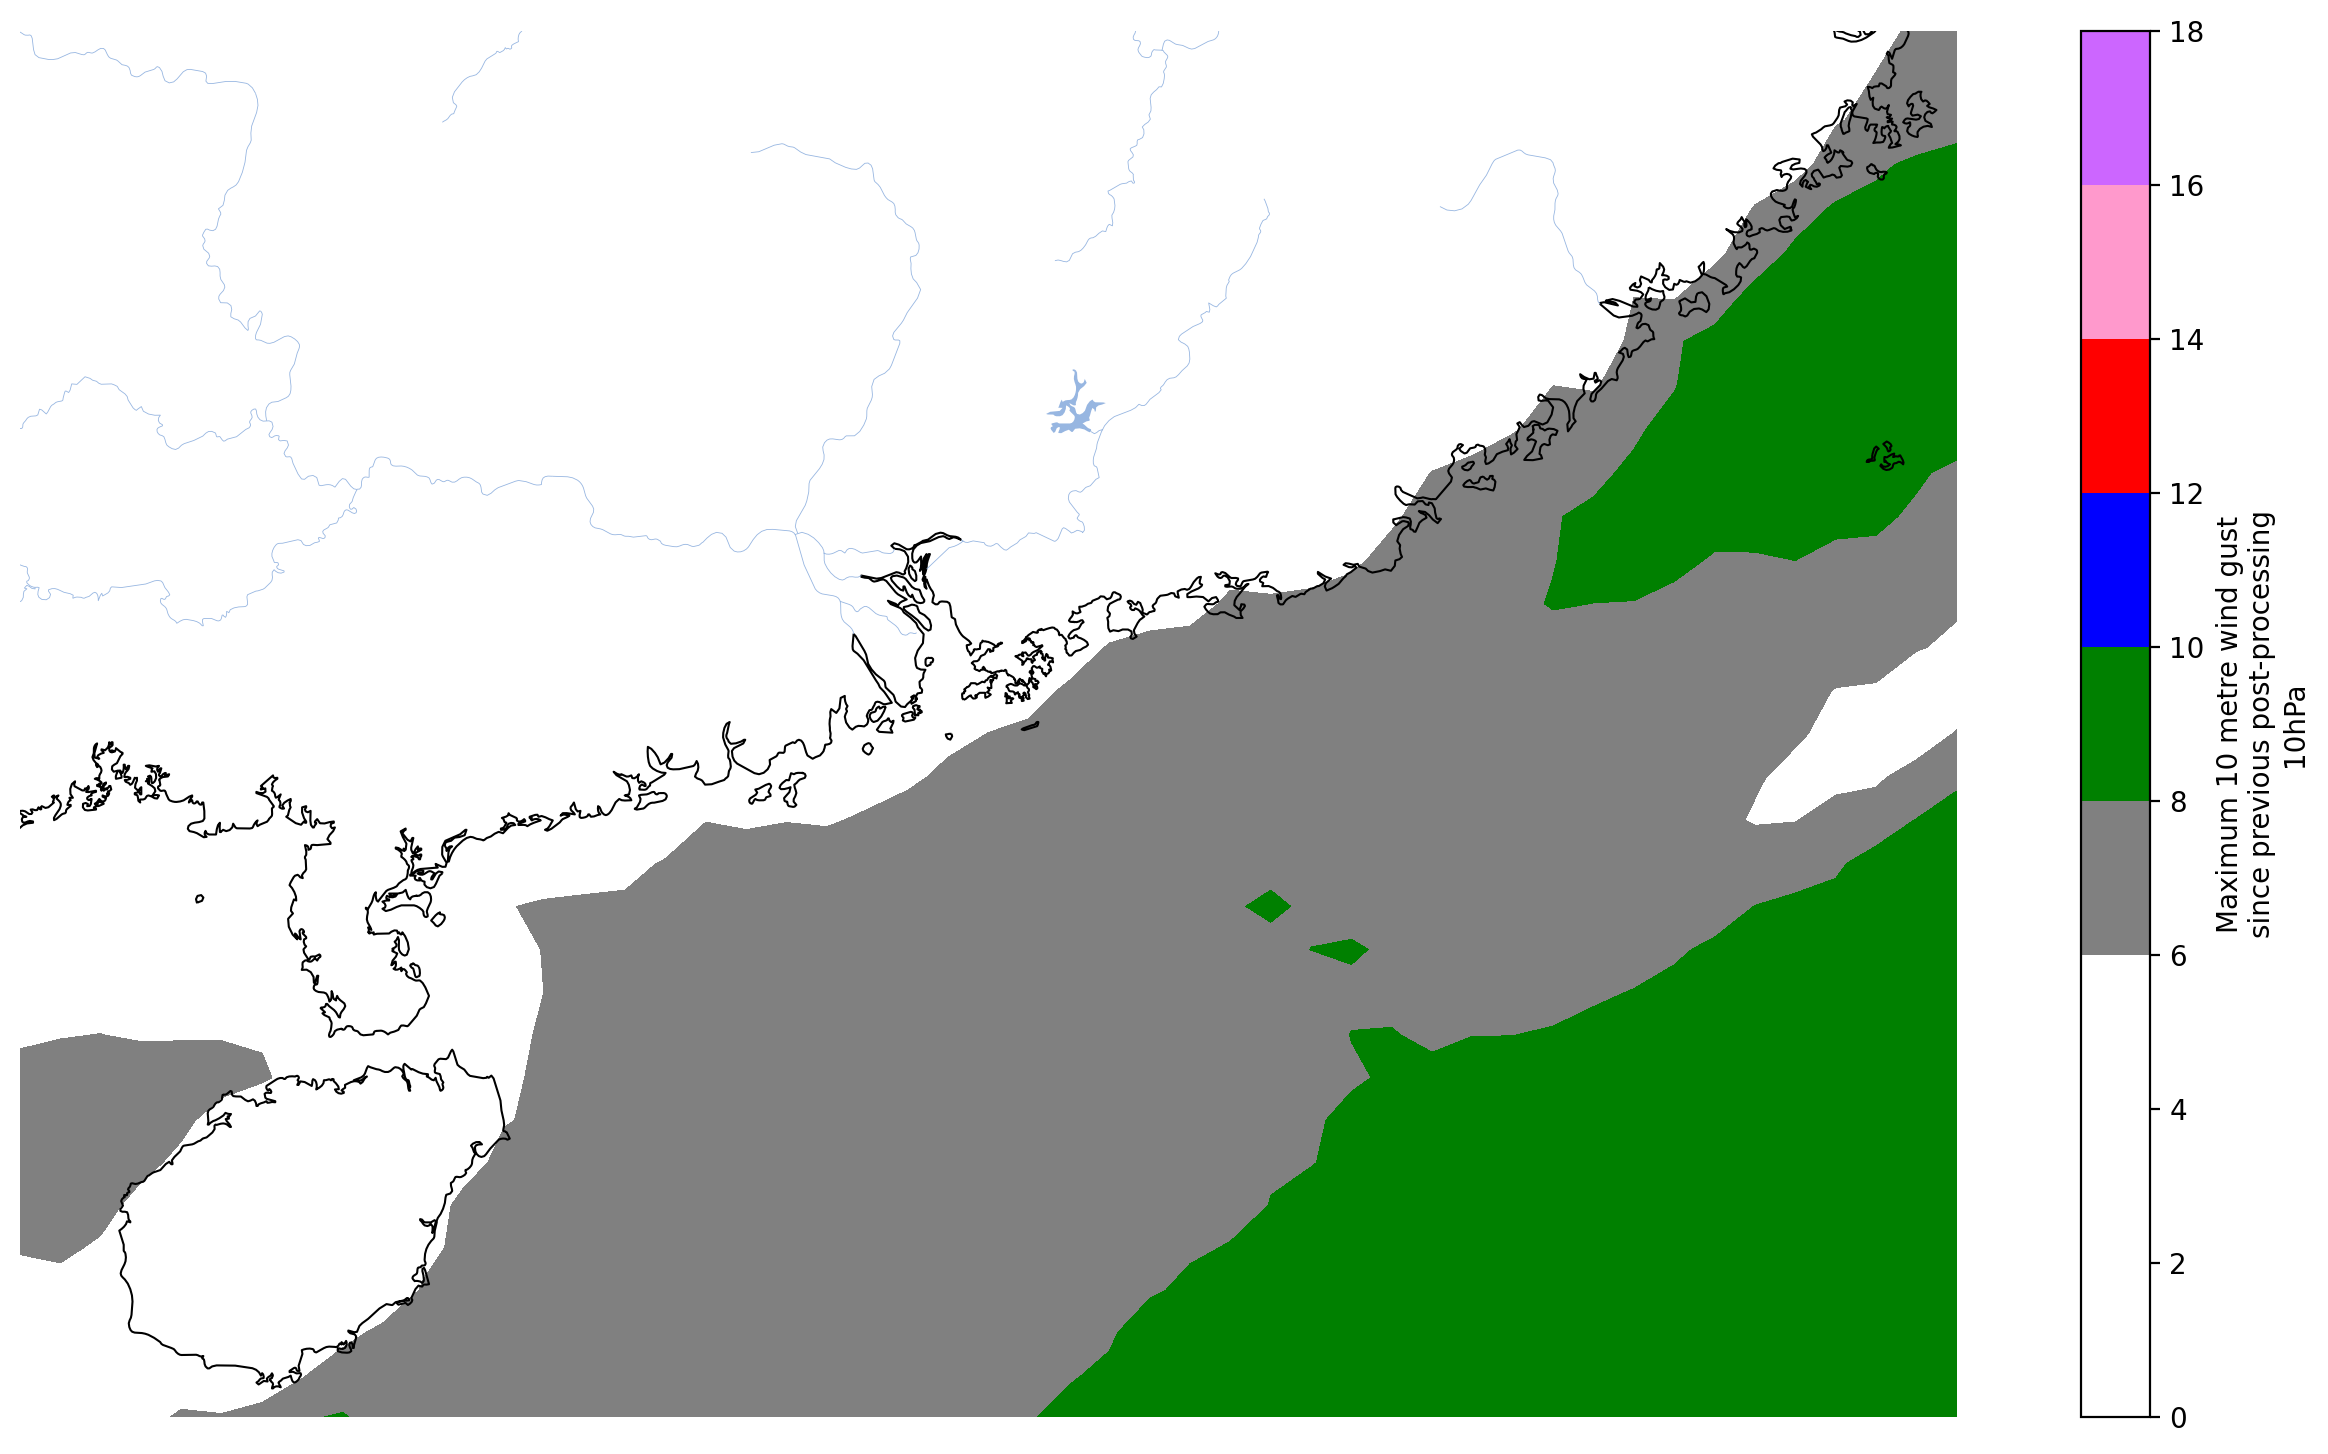

In [ ]:
#@title plot to dataset

def plot_dataset(dataset : xr.Dataset):
    projection = ccrs.Mercator()

    crs = ccrs.PlateCarree()

    plt.figure(figsize=(16,9), dpi=200)
    ax = plt.axes(projection=projection, frameon=False)

    # gl.ylabel_style = {"size" : 7}
    # To plot borders and coastlines, we can use cartopy feature
    import cartopy.feature as cf
    ax.add_feature(cf.COASTLINE.with_scale("10m"), lw=0.75)
    ax.add_feature(cf.RIVERS.with_scale("10m"), lw=0.3)
    ax.add_feature(cf.LAKES.with_scale("10m"), lw=0.3)

    lon_min = 108
    lon_max = 120
    lat_min = 18
    lat_max = 26

    cbar_kwargs = {'orientation':'horizontal', 'shrink':0.75, "pad" : .05, 'aspect':8, 'label':''}

    colors = ["white", "white", "white", "grey", "green", "blue", "red", "#ff99cc", "#cc66ff"]

    dataset.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=10, vmin=0, vmax=18, colors=colors)

    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    #plt.title(f"Temperature anomaly over Europe in {dataset.valid_time.dt.strftime('%B %Y').values}")
    plt.show()


x = np.fabs(ds["Maximum 10 metre wind gust since previous post-processing 10hPa"]) / 0.836
x = np.power(x, 2/3)
plot_dataset(x)

#10u -> ds["10 metre U wind component 10hPa"]

In [ ]:
#@title hidden

msl = ds["Surface pressure"] / 100
type(msl)
msl = msl



#msl.plot()
#msl.plot.contour()

In [ ]:
#@title hidden

import cartopy.crs as ccrs

p = msl.plot(

    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),

    transform=ccrs.PlateCarree(),

)



p.axes.set_global()

p.axes.coastlines()